In [50]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [51]:
df = pd.read_csv('/Users/jyots/Desktop/DS_Projects/airbnb_DataSets/Paris_dfm.csv',
                   encoding='utf8')

In [52]:
df.head(2)

,Unnamed: 0,bathrooms,bedrooms,bhk,dist_arprt,host_count,metrostn_count,minstay,neighborhood,overall_satisfaction,price,rest_count,review_count,reviews,room_type
0,0,1.0,1.0,1.0,0.19109,478,6,2.0,Amerique,5.0,93.0,1,3682,7,Entire home/apt
1,1,1.0,1.0,1.0,0.19109,478,6,2.0,Amerique,4.5,73.0,1,3682,31,Entire home/apt


In [53]:
df.drop('Unnamed: 0', inplace=True, axis=1)

In [54]:
#df['pproom'] = (df['price'] * df['minstay'])/df['bhk']

In [55]:
#df['pproom']

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet, LassoCV, Lasso

import patsy

In [57]:
df = df[df.price <= 1000]


In [58]:
df.shape

(41124, 14)

In [59]:
X = df[[x for x in df.columns if x not in ['bhk','price']]]
y = df.price.values
target = np.log(y)


In [60]:
formula = "target ~ "+' + '.join(X)+' -1'
formula

u'target ~ bathrooms + bedrooms + dist_arprt + host_count + metrostn_count + minstay + neighborhood + overall_satisfaction + rest_count + review_count + reviews + room_type -1'

In [61]:
y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
y = y.values.ravel()

In [62]:
y

array([ 4.53259949,  4.29045944,  3.91202301, ...,  4.61512052,
        6.10479323,  4.49980967])

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [64]:
X_train.shape, X_test.shape

((28786, 92), (12338, 92))

In [65]:
X_test.head(2)

,neighborhood[Amerique],neighborhood[Archives],neighborhood[Arsenal],neighborhood[Arts-et-Metiers],neighborhood[Auteuil],neighborhood[Batignolles],neighborhood[Bel-Air],neighborhood[Belleville],neighborhood[Bercy],neighborhood[Bonne-Nouvelle],...,bathrooms,bedrooms,dist_arprt,host_count,metrostn_count,minstay,overall_satisfaction,rest_count,review_count,reviews
15158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.234649,1372.0,3.0,3.0,4.5,4.0,20941.0,5.0
17120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.242496,577.0,3.0,6.0,2.0,19.0,10871.0,0.0


In [66]:
linmod = LinearRegression()

In [67]:
scores = cross_val_score(linmod, X_train, y_train, cv = 10)
print scores
print np.mean(scores)
print np.std(scores)

[ 0.59158691  0.60099701  0.57612883  0.60234444  0.58190897  0.59968785
  0.61539561  0.57928697  0.60171193  0.59257526]
0.594162379293
0.0116525503228


In [68]:
predictions = cross_val_predict(linmod, X_test, y_test, cv = 10) 
accuracy = metrics.r2_score(y_test, predictions)
print accuracy


0.578797617766


In [69]:
residuals = y_test - predictions
residuals

array([-0.08902061, -0.08190812, -0.60428372, ...,  0.05361115,
       -0.46504277, -0.59386573])

In [70]:
np.mean(predictions)


4.5812206983971056

In [71]:
linmod.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [72]:
linmod.score(X_test, y_test)

0.58206049940169668

In [73]:
#linmod.coef_

In [74]:
print np.mean(y_train), np.mean(y_test)

4.57637354399 4.5813049508


In [75]:
# Regularization: Gridsearch an optimal ElasticNet regression

In [76]:
Xn = StandardScaler().fit_transform(X)

In [77]:
Xn_train, Xn_test, y_train, y_test = train_test_split(Xn, y, test_size = 0.3)

In [78]:
# enet_cv = ElasticNetCV(l1_ratio=np.linspace(0.01, 1., 50), n_alphas=300, cv=10, verbose=1)
# enet_cv.fit(Xn_train, y_train)


In [79]:
# print enet_cv.l1_ratio_
# print enet_cv.alpha_

In [80]:
# enet = ElasticNet(alpha= enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_)

# y_pred_enet = enet.fit(Xn_train, y_train).predict(Xn_test)
# r2_score_enet = metrics.r2_score(y_test, y_pred_enet)
# print(enet)
# print("r^2 on test data : %f" % r2_score_enet)


In [81]:
lassocv = LassoCV(n_alphas=300, cv=10)

In [82]:
lassocv.fit(Xn_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=300, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [83]:
lassocv.alpha_

0.00030593575526846937

In [84]:
lasso = Lasso(alpha=lassocv.alpha_)
lasso_model = lasso.fit(Xn_train, y_train)
y_pred_lasso = lasso_model.predict(Xn_test)
r2_score_lasso = metrics.r2_score(y_test, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)


Lasso(alpha=0.00030593575526846937, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.590177


In [85]:
residuals = np.exp(y_test) - np.exp(y_pred_lasso)

In [86]:
neg_resd = [x for x in residuals.tolist() if x<0]
len(neg_resd)

6233

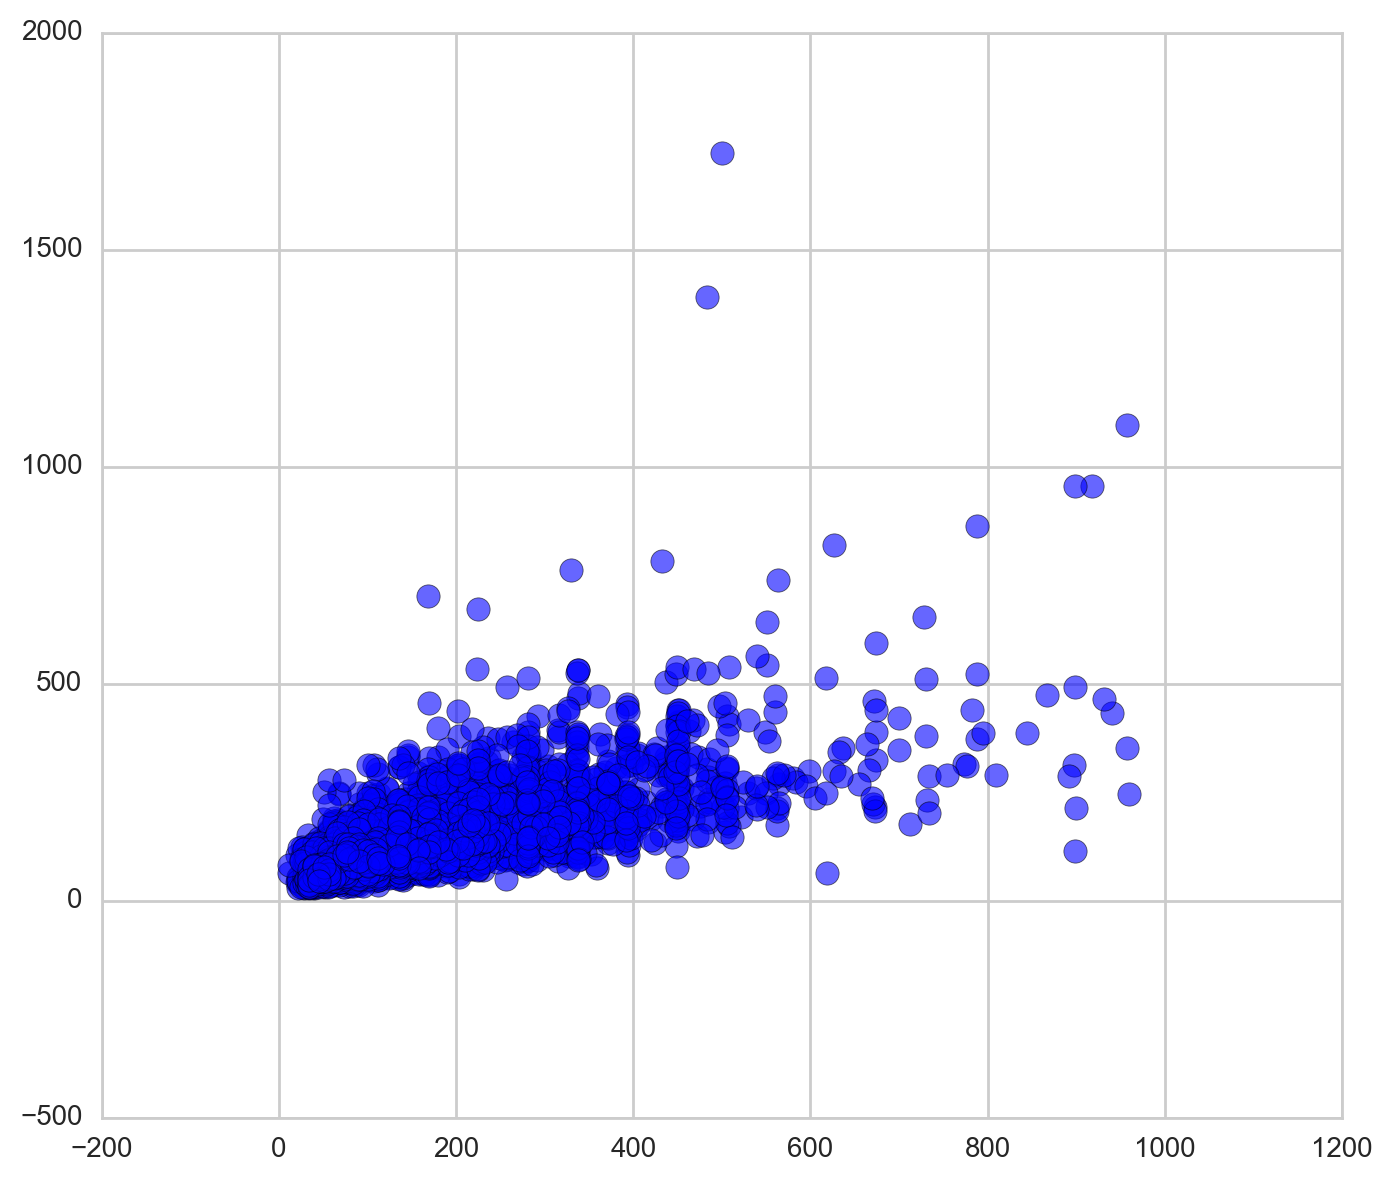

In [87]:
fig, ax = plt.subplots(figsize=(8,7))
ax.scatter(np.exp(y_test), np.exp(y_pred_lasso), s=70, alpha=0.6)
plt.show()

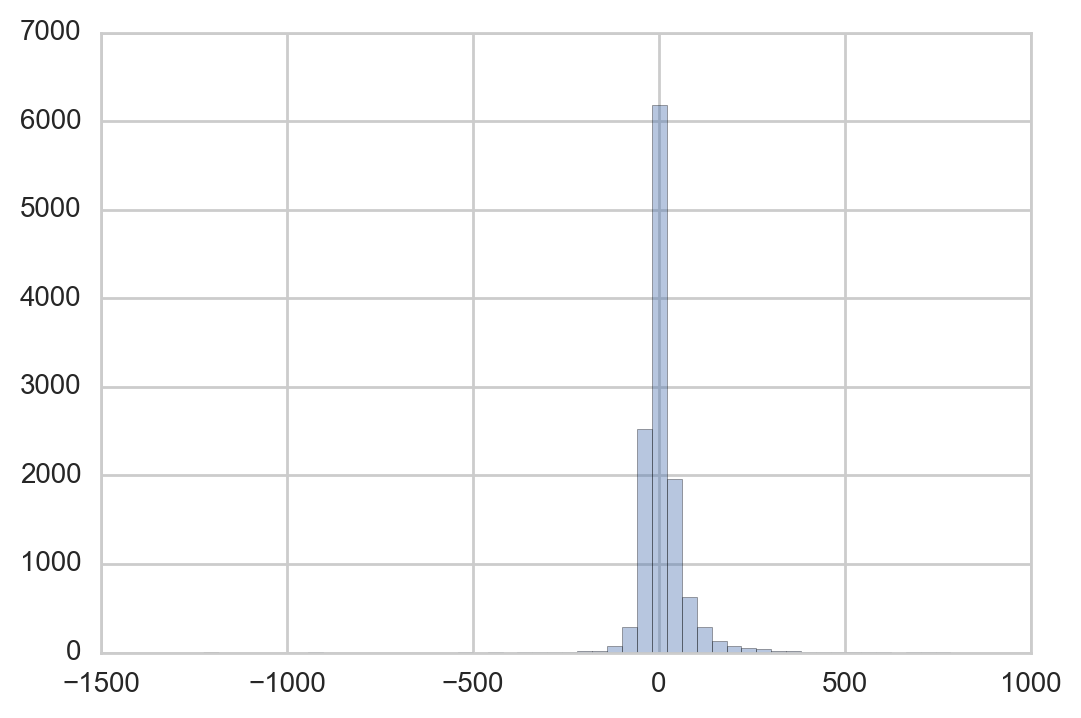

In [88]:
sns.distplot(residuals, bins=50, kde=False)

In [89]:
lasso.fit(Xn_train, y_train)

lasso_coef = pd.DataFrame({
        'variable':X_train.columns,
        'coef':lasso.coef_,
        'abscoef':np.abs(lasso.coef_)
    })

lasso_coef.sort_values('abscoef', ascending=False, inplace=True)
lasso_coef[lasso_coef.coef != 0].head(25)


,abscoef,coef,variable
83,0.269022,0.269022,bedrooms
80,0.152537,-0.152537,room_type[T.Private room]
84,0.100299,0.100299,dist_arprt
81,0.085146,-0.085146,room_type[T.Shared room]
82,0.071452,0.071452,bathrooms
89,0.067161,0.067161,rest_count
85,0.066732,-0.066732,host_count
90,0.065077,0.065077,review_count
43,0.040768,0.040768,neighborhood[Notre-Dame]
62,0.036521,0.036521,neighborhood[Saint-Avoye]


In [90]:
lasso_coef.sort_values('abscoef', ascending=False, inplace=True)

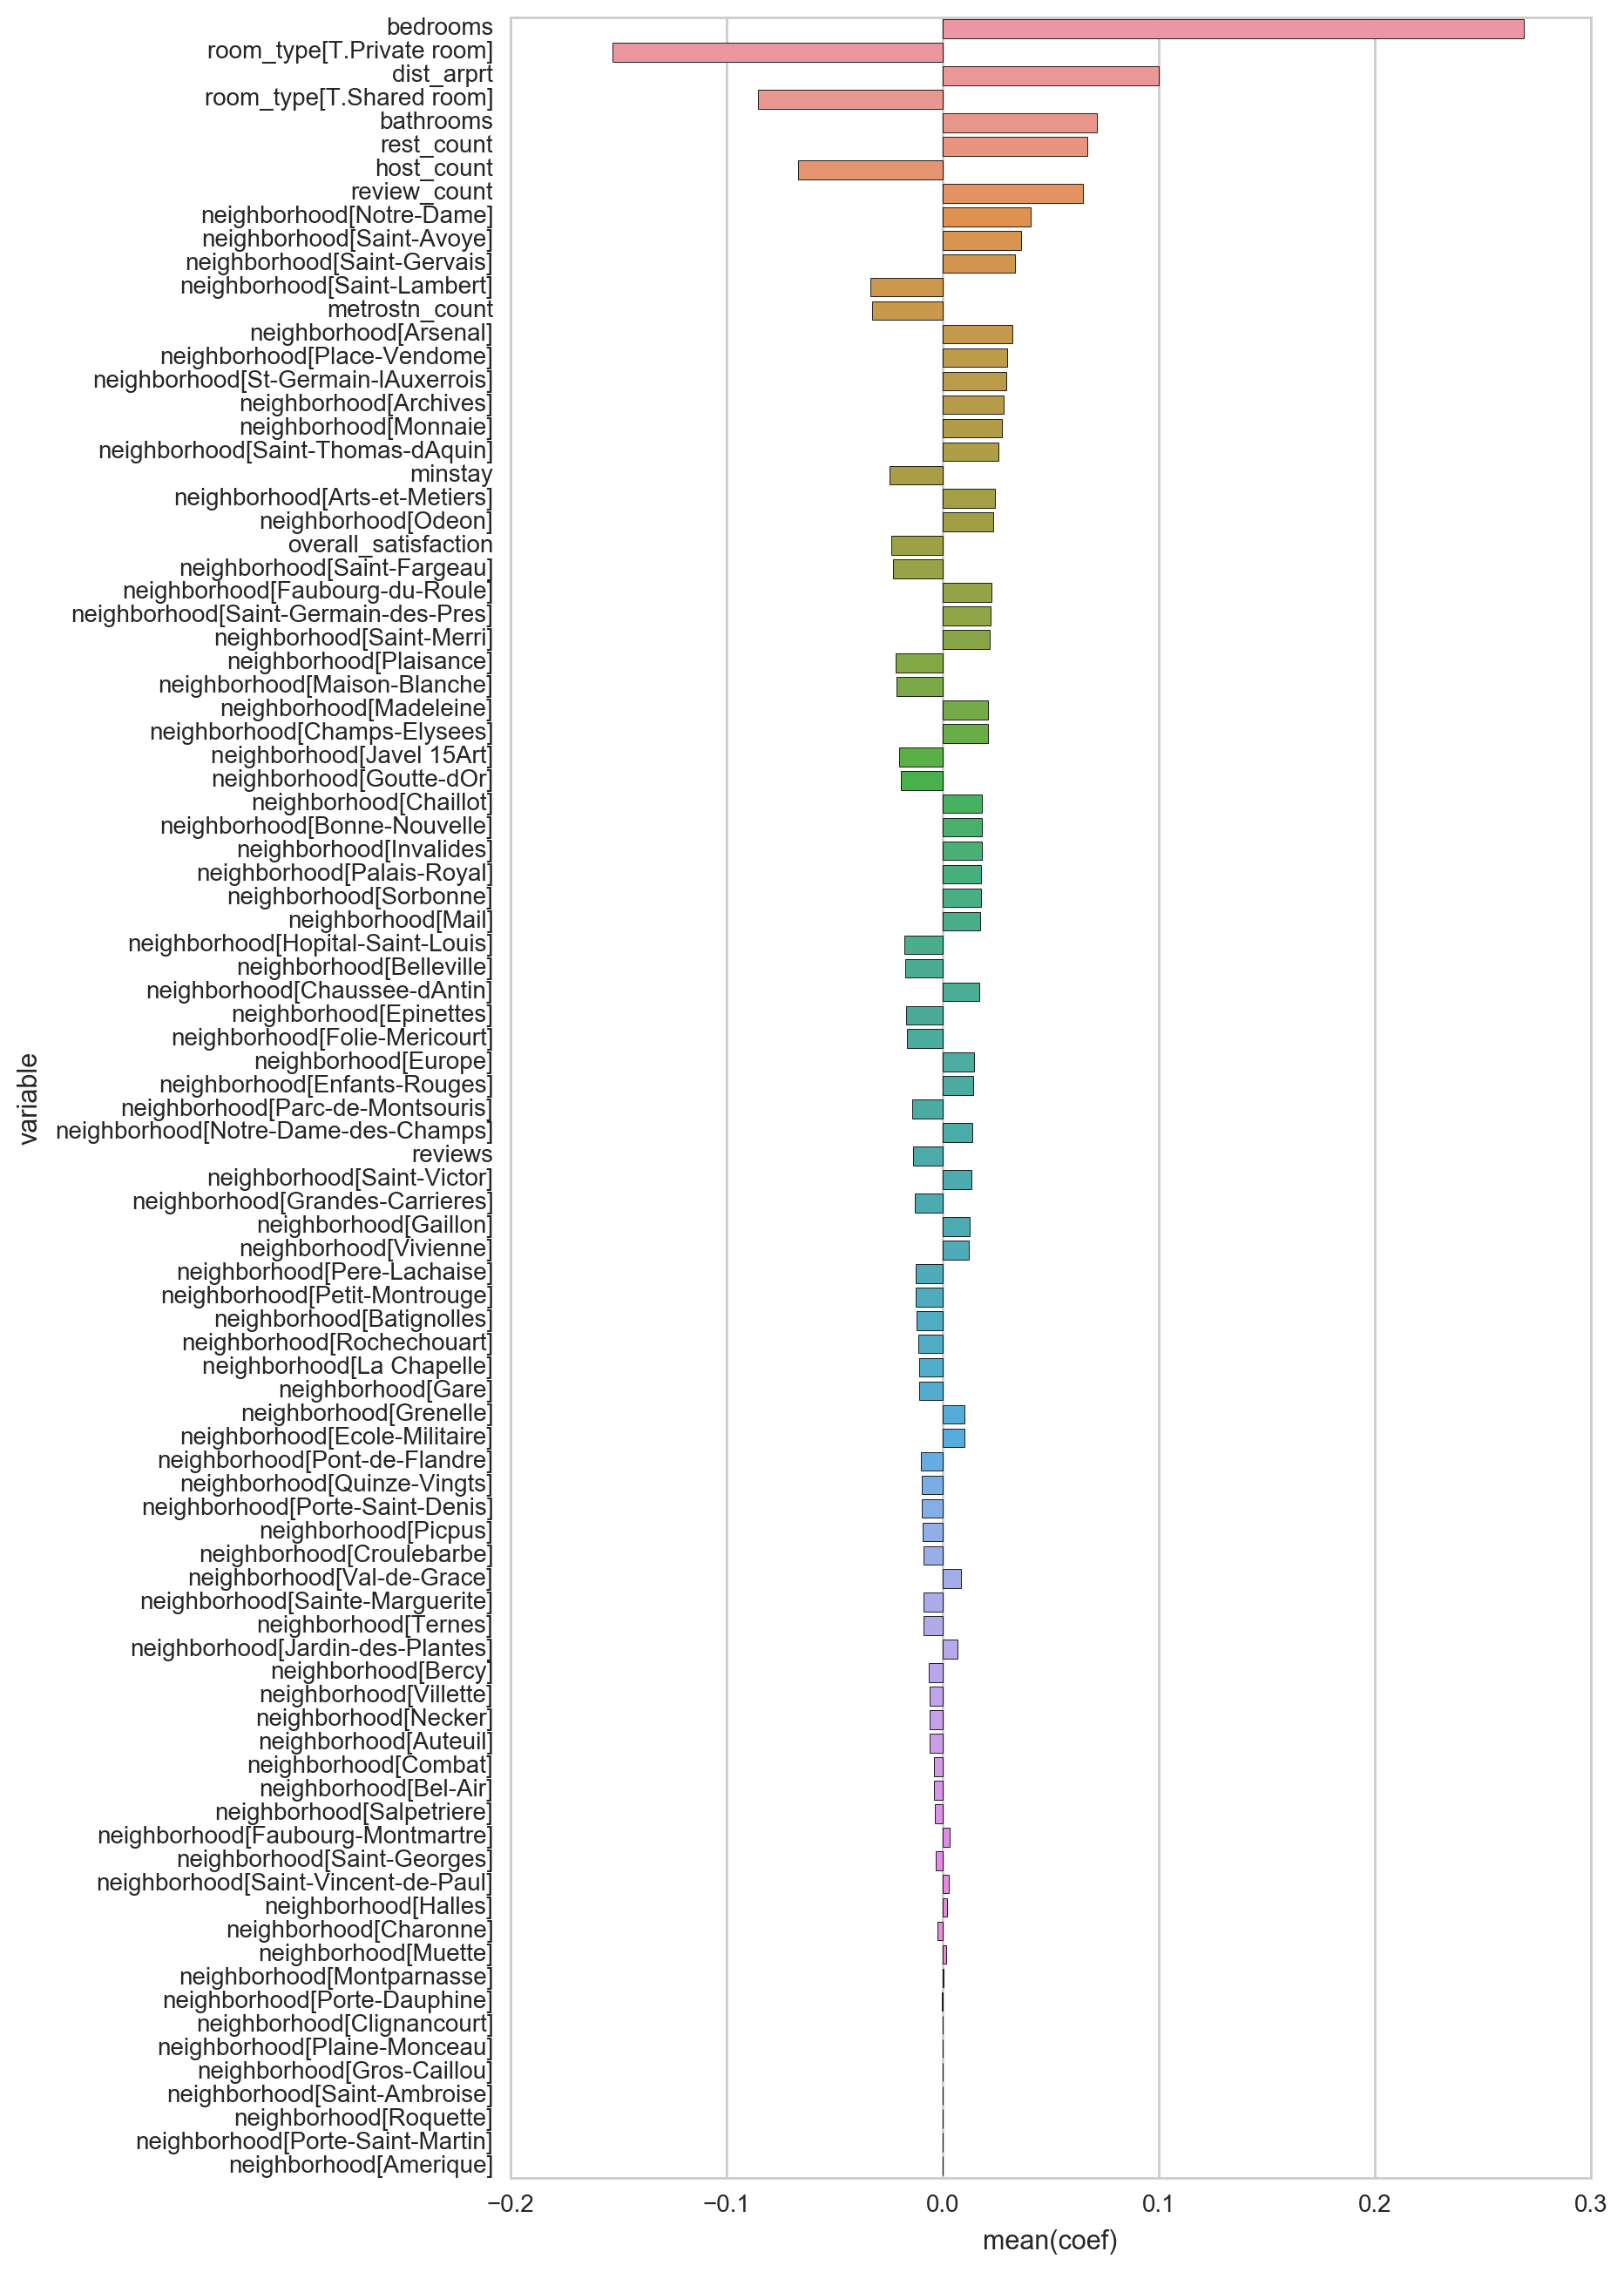

In [91]:
fig, ax = plt.subplots(figsize=(8,16))

sns.barplot(y = lasso_coef.variable, x = lasso_coef.coef, data=lasso_coef)


In [92]:
lasso_coef = lasso_coef.reset_index(drop=True)

In [93]:
lasso_coef

,abscoef,coef,variable
0,0.269022,0.269022,bedrooms
1,0.152537,-0.152537,room_type[T.Private room]
2,0.100299,0.100299,dist_arprt
3,0.085146,-0.085146,room_type[T.Shared room]
4,0.071452,0.071452,bathrooms
5,0.067161,0.067161,rest_count
6,0.066732,-0.066732,host_count
7,0.065077,0.065077,review_count
8,0.040768,0.040768,neighborhood[Notre-Dame]
9,0.036521,0.036521,neighborhood[Saint-Avoye]


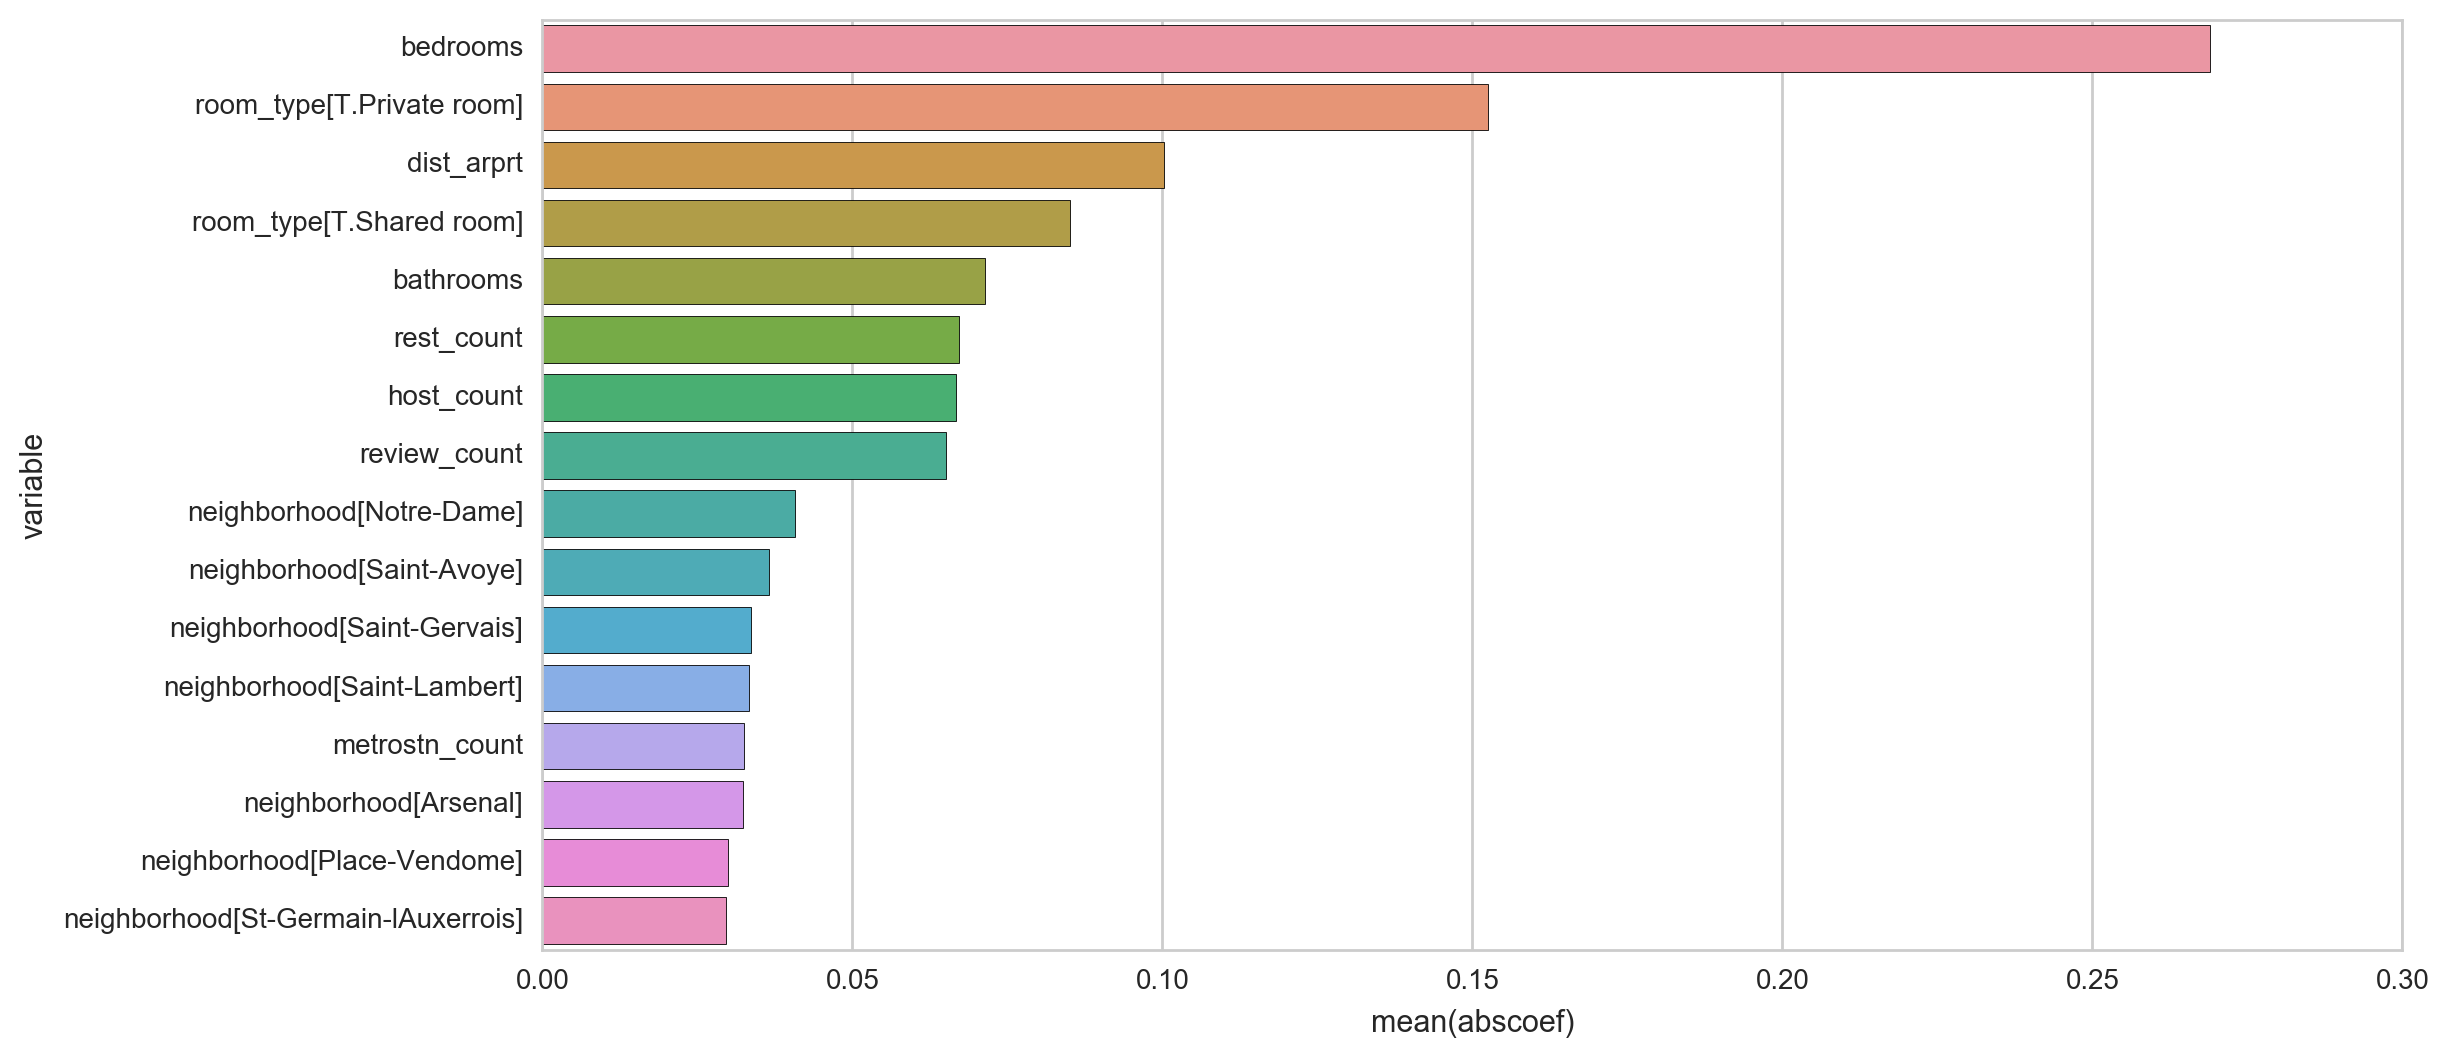

In [94]:
fig, ax = plt.subplots(figsize=(12,6))

sns.barplot(y = lasso_coef.loc[0:15,:].variable, x = lasso_coef.loc[0:15,:].abscoef, data=lasso_coef.loc[0:15,:]
           )


In [95]:
tmp = X_train.reset_index(drop=True)
tmp = tmp.loc[np.abs(residuals) >= 2.5]
#tmp

In [96]:
#tmp.ix[7670,:]

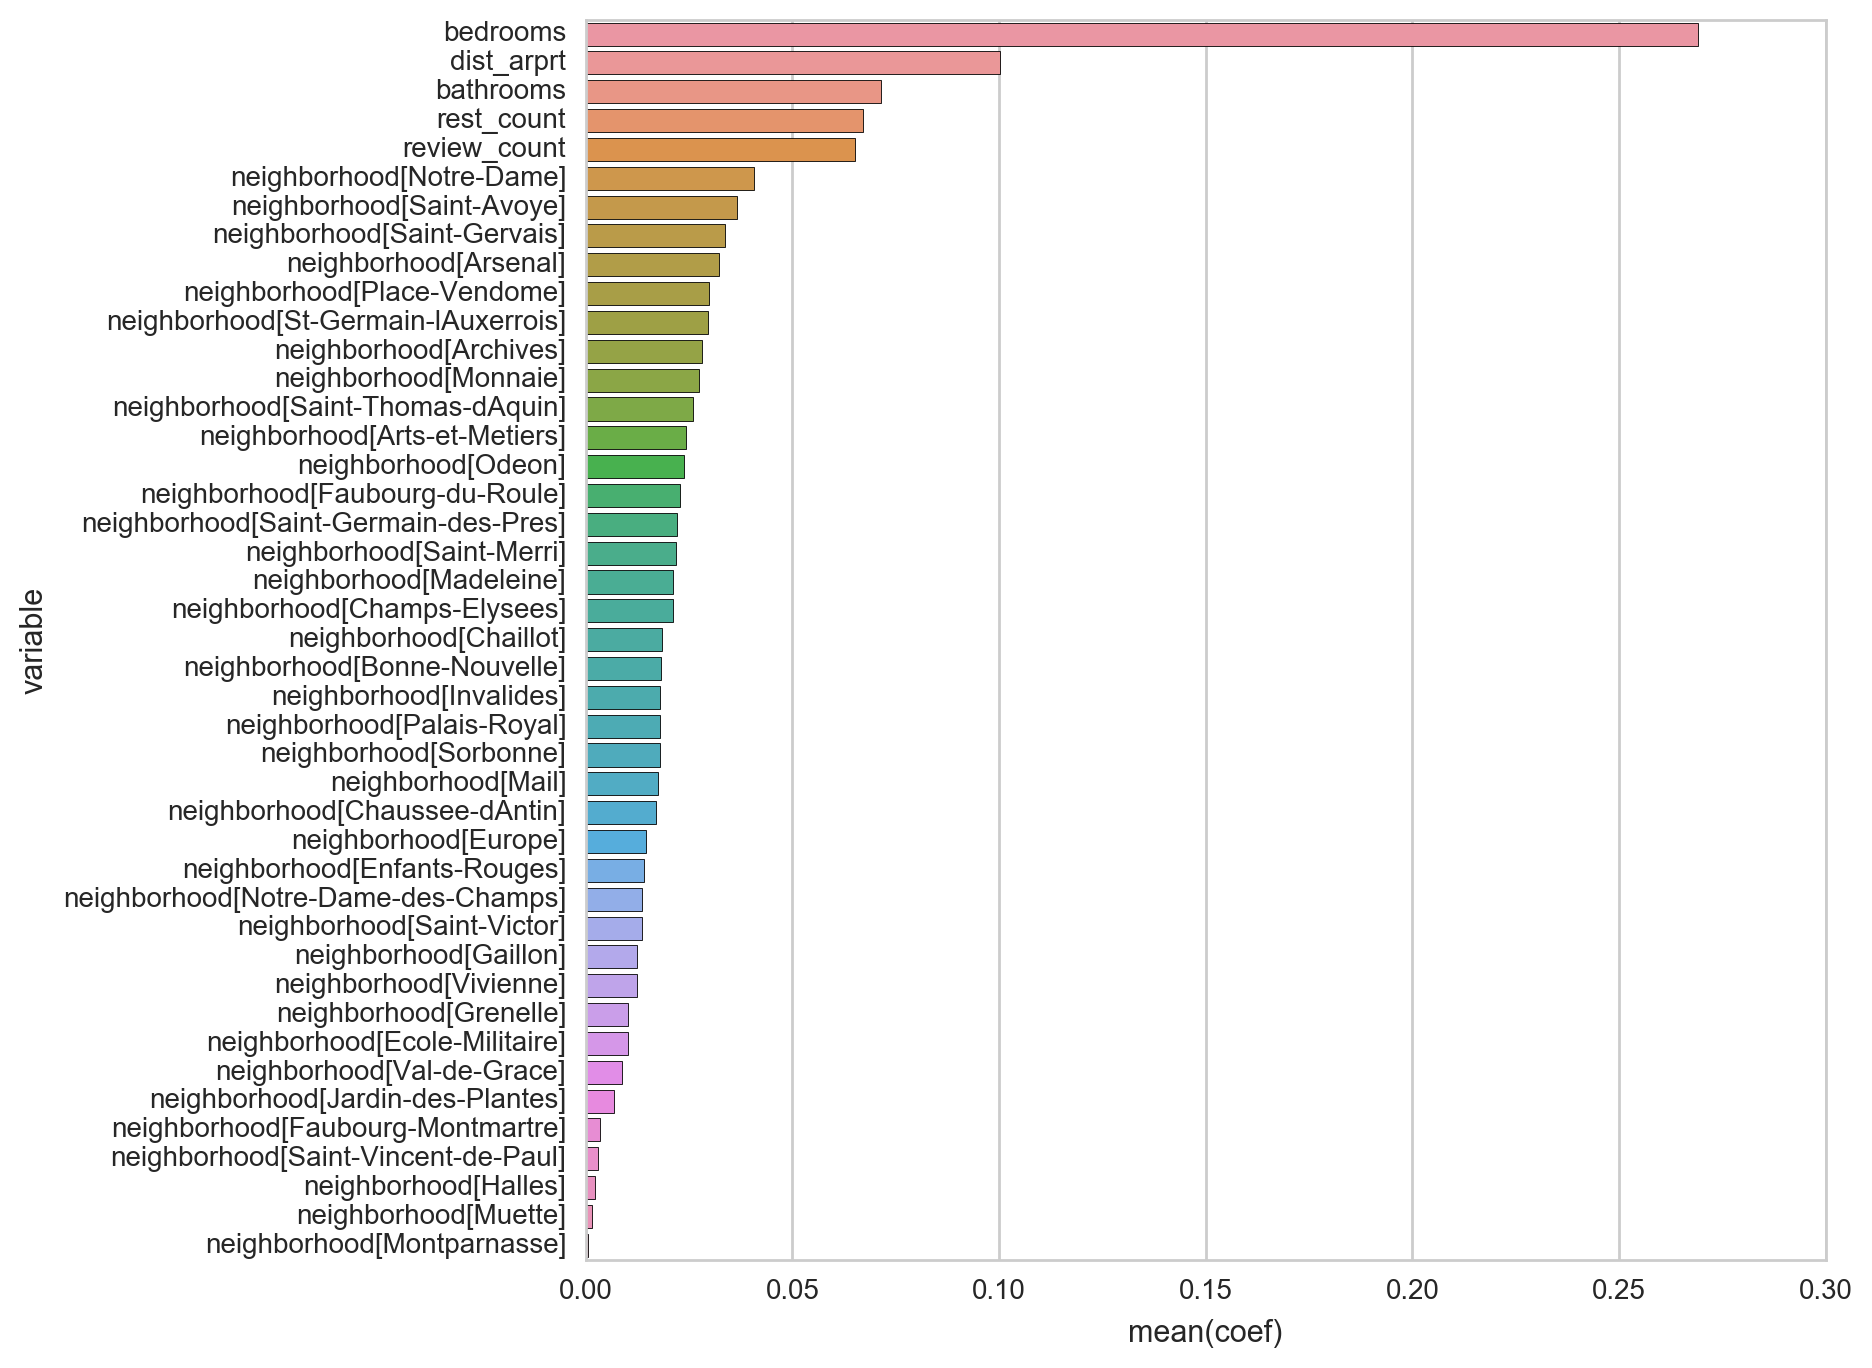

In [97]:
fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(y = lasso_coef[lasso_coef.coef > 0].variable, x = lasso_coef[lasso_coef.coef > 0].coef, data=lasso_coef,
            ax=ax
           )
plt.show()

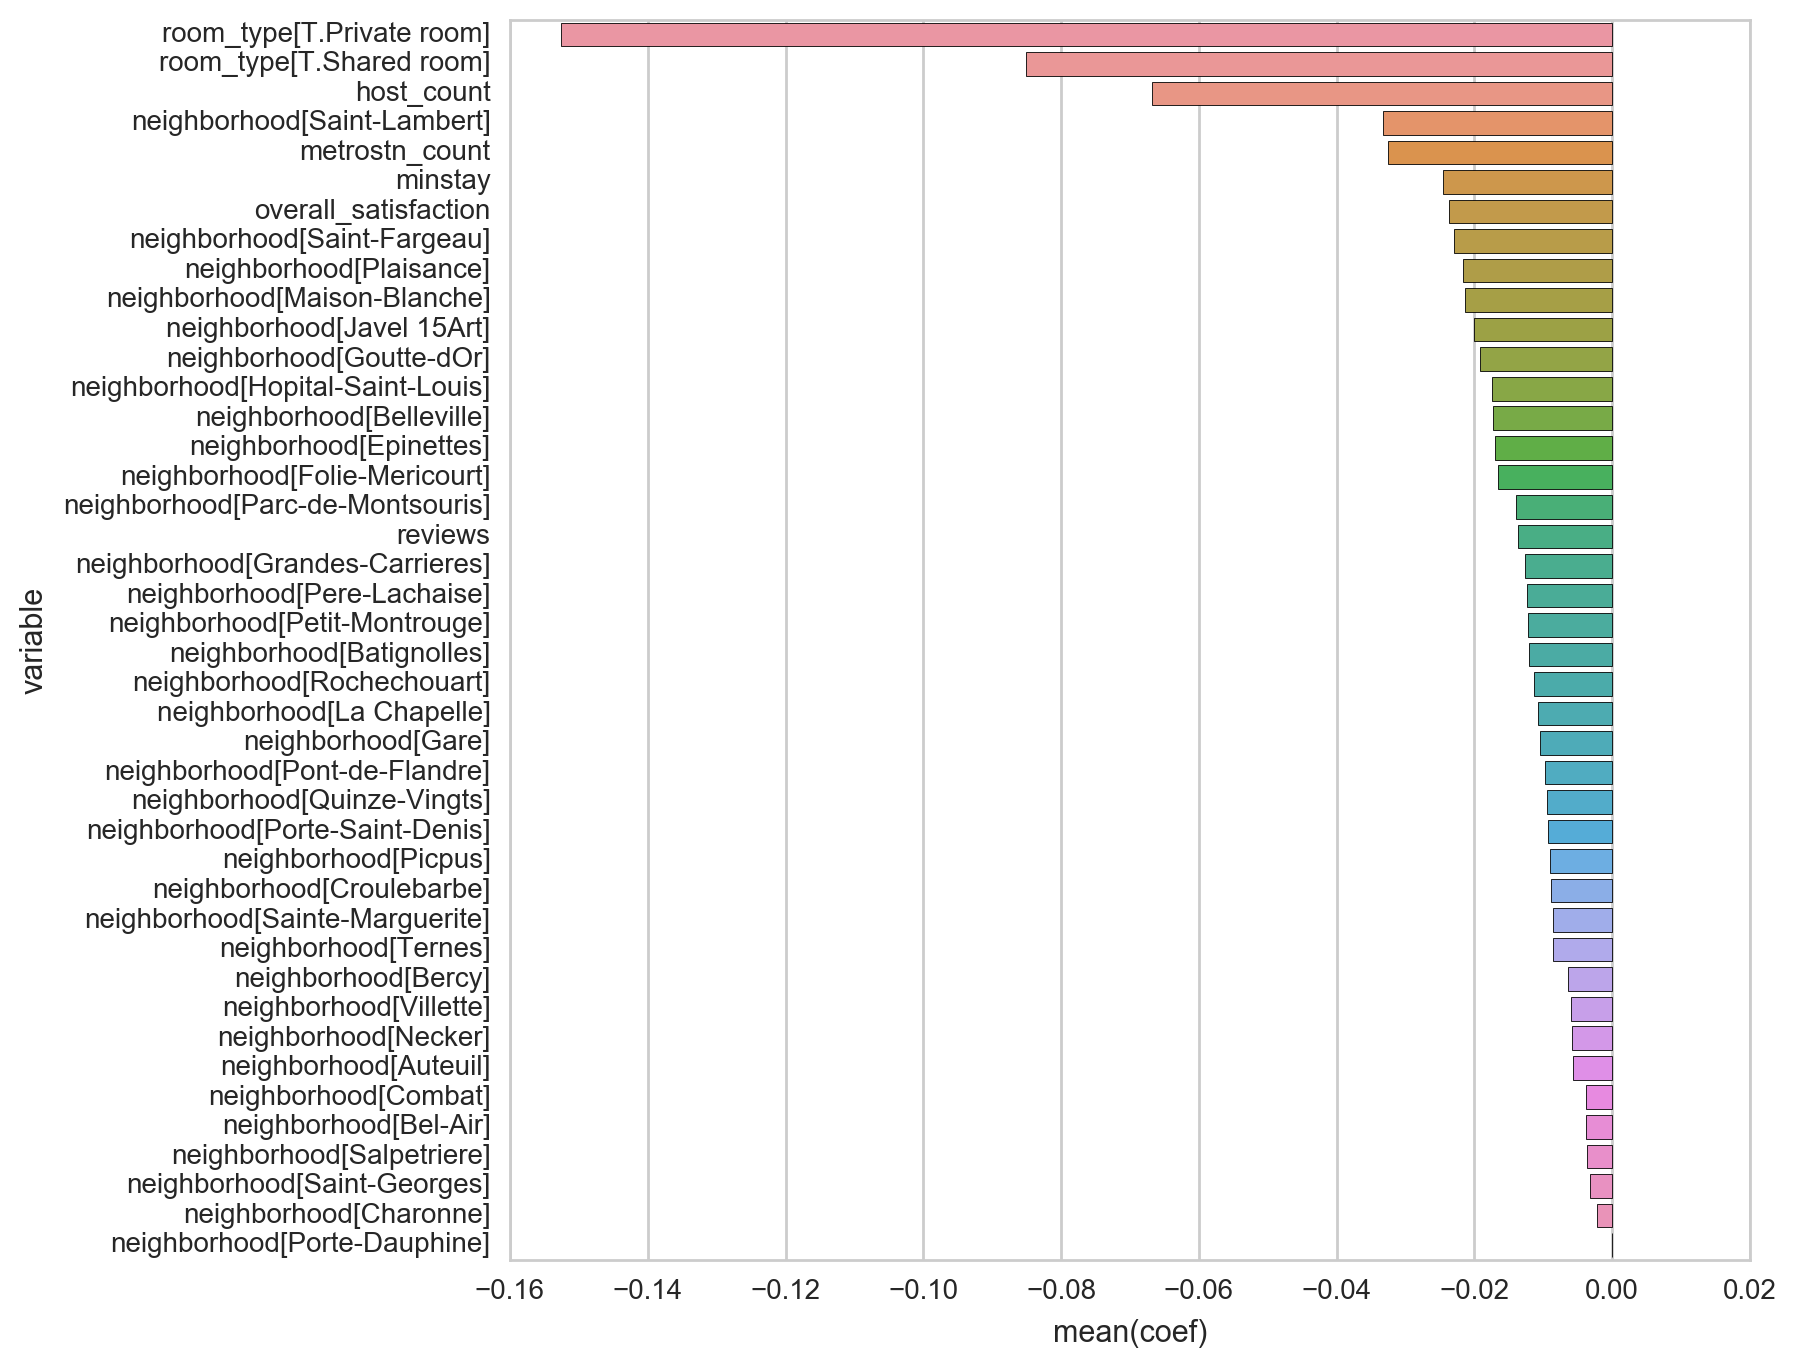

In [98]:
fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(y = lasso_coef[lasso_coef.coef < 0].variable, x = lasso_coef[lasso_coef.coef < 0].coef, data=lasso_coef,
            ax=ax
           )
plt.show()